## Exploratory Data Analysis and Building a Binary Hit Classifier

Now we will attempt to build a classification model to predict whether a given batted ball will be a hit or an out based on Statacast and stadium dimension features scraped in Notebooks 01 and 02, and engineered in the previous notebook. Since we are interested in prediction and some level of interpretability (to understand which features have predictive value) we'll focus on `scikit-learn`'s `LogisticRegressionClassifier`, `RandomForestClassifier` and `GradientBoostingClassifier` for now. 

We'll first see that our data is moderately imbalanced (fewer hits compared to outs) and that discriminating between hits and outs is much clearer through the features describing the nature of contact for a batted ball -- very crudely, how hard/far the ball is hit (`launch_speed`) , how high the ball is hit (`launch_angle`) and the general direction othe ball is hit (`spray_angle`).

Since the data is moderately imbalanced, we'll use both setting the `class_weight` parameter to `'balanced'` and [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) to attempt to balance the data for the `LogisticRegressionClassifier` and `RandomForestClassifier`. This is not done for `GradientBoostingClassifier` which can [directly handle imbalance](https://datascience.stackexchange.com/questions/1107/quick-guide-into-training-highly-imbalanced-data-sets) in its training algorithm.

We compare and select from these models using `GridSearchCV` on different hyperparamters while scoring using `roc_auc_score` as we ultimately want to predict as many hits correctly as possible without mis-classifying too many outs as hits. For the selected model, we further tune hyperparameters using `fbeta_score` with `beta = 2` to further prioritize identifying true hits correctly (higher Recall) without completely mismanaging the [Precision-Recall tradeoff](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) by identifying too many true outs as hits as well ("reasonable" Precision).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from copy import copy, deepcopy
import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score, roc_curve, make_scorer, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('statcast_full_clean.pkl', 'rb') as p:
    data = pickle.load(p)

In [3]:
data.head()

,game_date,game_year,home_team,away_team,def_team,at_bat_number,events,launch_angle,launch_speed,spray_angle,...,cf_ht,rf_ht,lf,lc,cf,rc,rf,hit_rate_wk,hit_rate_mo,hit
0,2015-04-06,2015,ARI,SF,ARI,1,field_out,14.2,95.1,17.190065,...,25,8,330,376,407,376,335,0.000000,0.000000,0
1,2015-04-06,2015,ARI,SF,ARI,2,single,18.0,69.3,11.669137,...,25,8,330,376,407,376,335,0.000000,0.000000,1
2,2015-04-06,2015,ARI,SF,ARI,3,double,1.0,95.4,-33.561451,...,25,8,330,376,407,376,335,0.500000,0.500000,1
3,2015-04-06,2015,ARI,SF,ARI,5,field_out,32.1,102.3,-0.910465,...,25,8,330,376,407,376,335,0.666667,0.666667,0
4,2015-04-06,2015,ARI,SF,ARI,10,field_out,-15.7,88.5,6.054393,...,25,8,330,376,407,376,335,0.500000,0.500000,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630221 entries, 0 to 630220
Data columns (total 23 columns):
game_date        630221 non-null object
game_year        630221 non-null int64
home_team        630221 non-null object
away_team        630221 non-null object
def_team         630221 non-null object
at_bat_number    630221 non-null int64
events           630221 non-null object
launch_angle     630221 non-null float64
launch_speed     630221 non-null float64
spray_angle      630221 non-null float64
fair             630221 non-null float64
foul             630221 non-null float64
lf_ht            630221 non-null int64
cf_ht            630221 non-null int64
rf_ht            630221 non-null int64
lf               630221 non-null int64
lc               630221 non-null int64
cf               630221 non-null int64
rc               630221 non-null int64
rf               630221 non-null int64
hit_rate_wk      630221 non-null float64
hit_rate_mo      630221 non-null float64
hit         

Having now loaded our full modeling DataFrame from the previous notebook, let's now split into Train and Test sets. For the former, we'll use the data from the 2015 through 2018 seasons, with the 2019 season data as the latter:

In [5]:
data_train = data[data['game_year'] < 2019]
data_test = data[data['game_year'] == 2019]

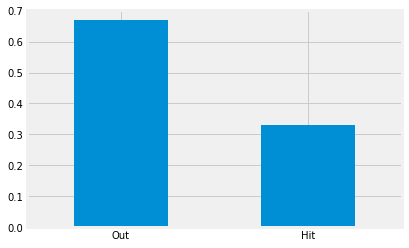

In [6]:
data_train['hit'].value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ['Out', 'Hit'], rotation=0);

In the training data, there appear to be roughly 2 outs for every hit. Let's now take a look at the overall distributions of the features, first on their own, then separating the hit and out outcomes:

In [7]:
# keep 'hit' in X for now just for EDA purposes
X_train = data_train.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events'])
X_test = data_test.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events'])
y_train = data_train['hit']
y_test = data_test['hit']

In [8]:
print(X_train.shape)
print(X_test.shape)

(506346, 16)
(123875, 16)


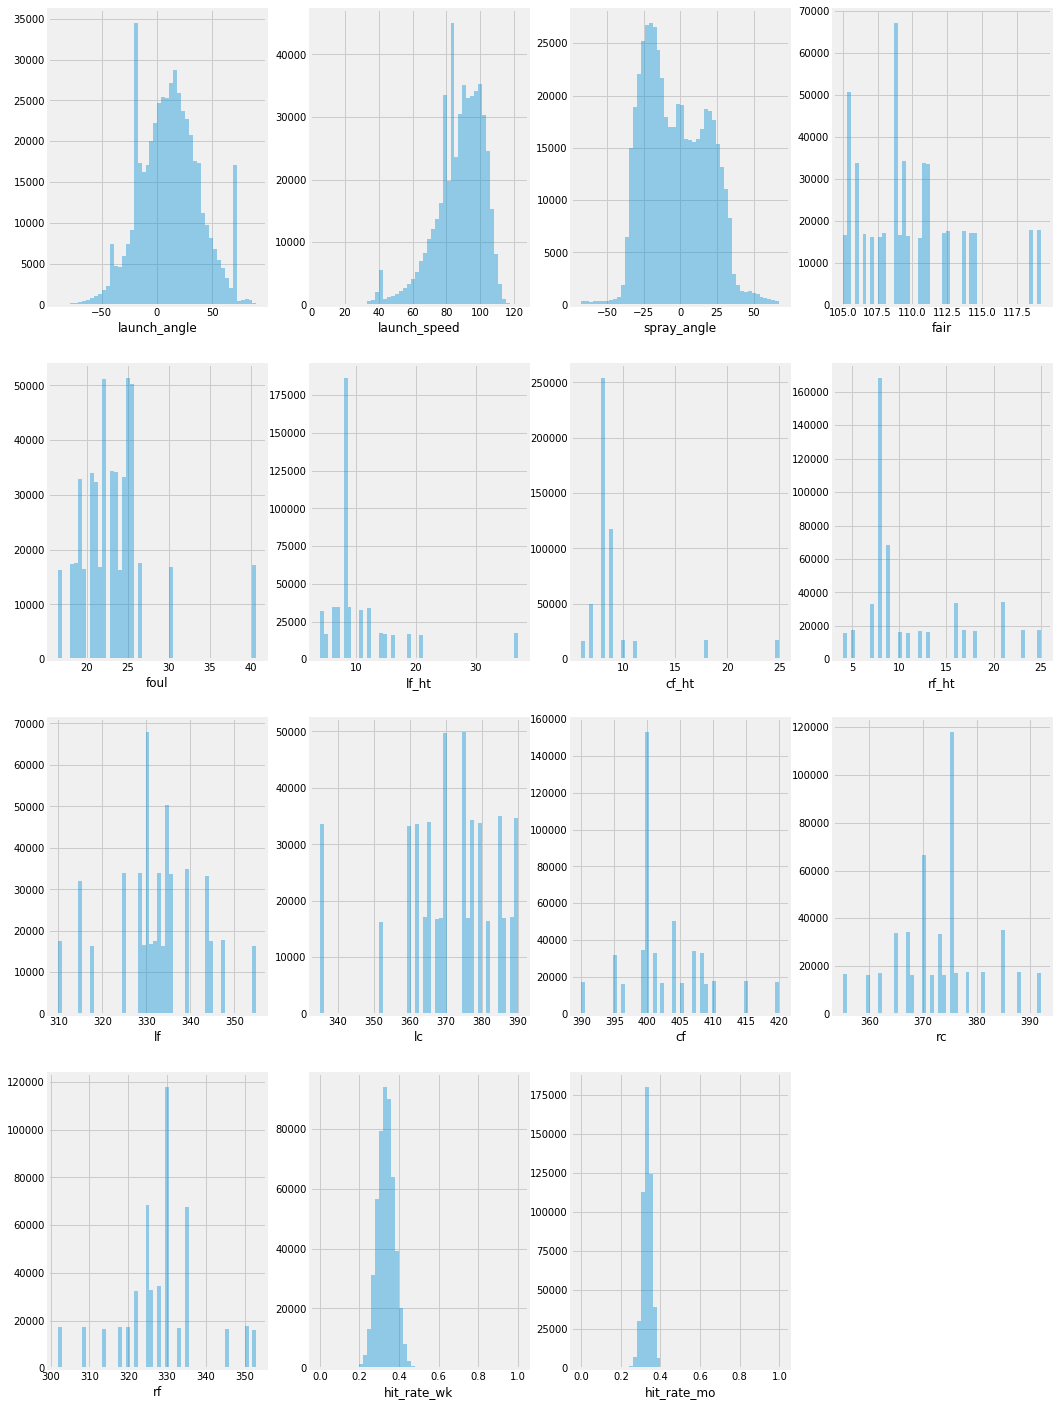

In [9]:
cols = X_train.columns
plt.figure(figsize=(16,25))
for i in range(len(cols)-1):
    plt.subplot(4, 4, i+1)
    sns.distplot(X_train[cols[i]],kde=False)

The above plots are not incredibly insightful, but we can see that there is not that much variation in stadium dimensions (particuarly in outfield dimesions and outfield wall heights, with a bit more in fair and foul territory). Of the "contact" features, `launch_angle` is nearly symmetrical with some additional peaks at some highly negative (just about any weak groundball?) and positive values (pop-ups?), `launch_speed` appears to mostly take on values between 70 and 100 mph, and `spray_angle` appears almost tri-modal reflecting a relative balance in batted balls that are up the middle (values around zero) or opposite field (positive), with a larger peak of pulled batted balls (negative). As one might expect, the weekly and monthly hit rates don't really take on too wide a range of values, with the monthly rates taking on a much narrower range of values.

Now taking a look at each feature, separating the hit/out outcomes:

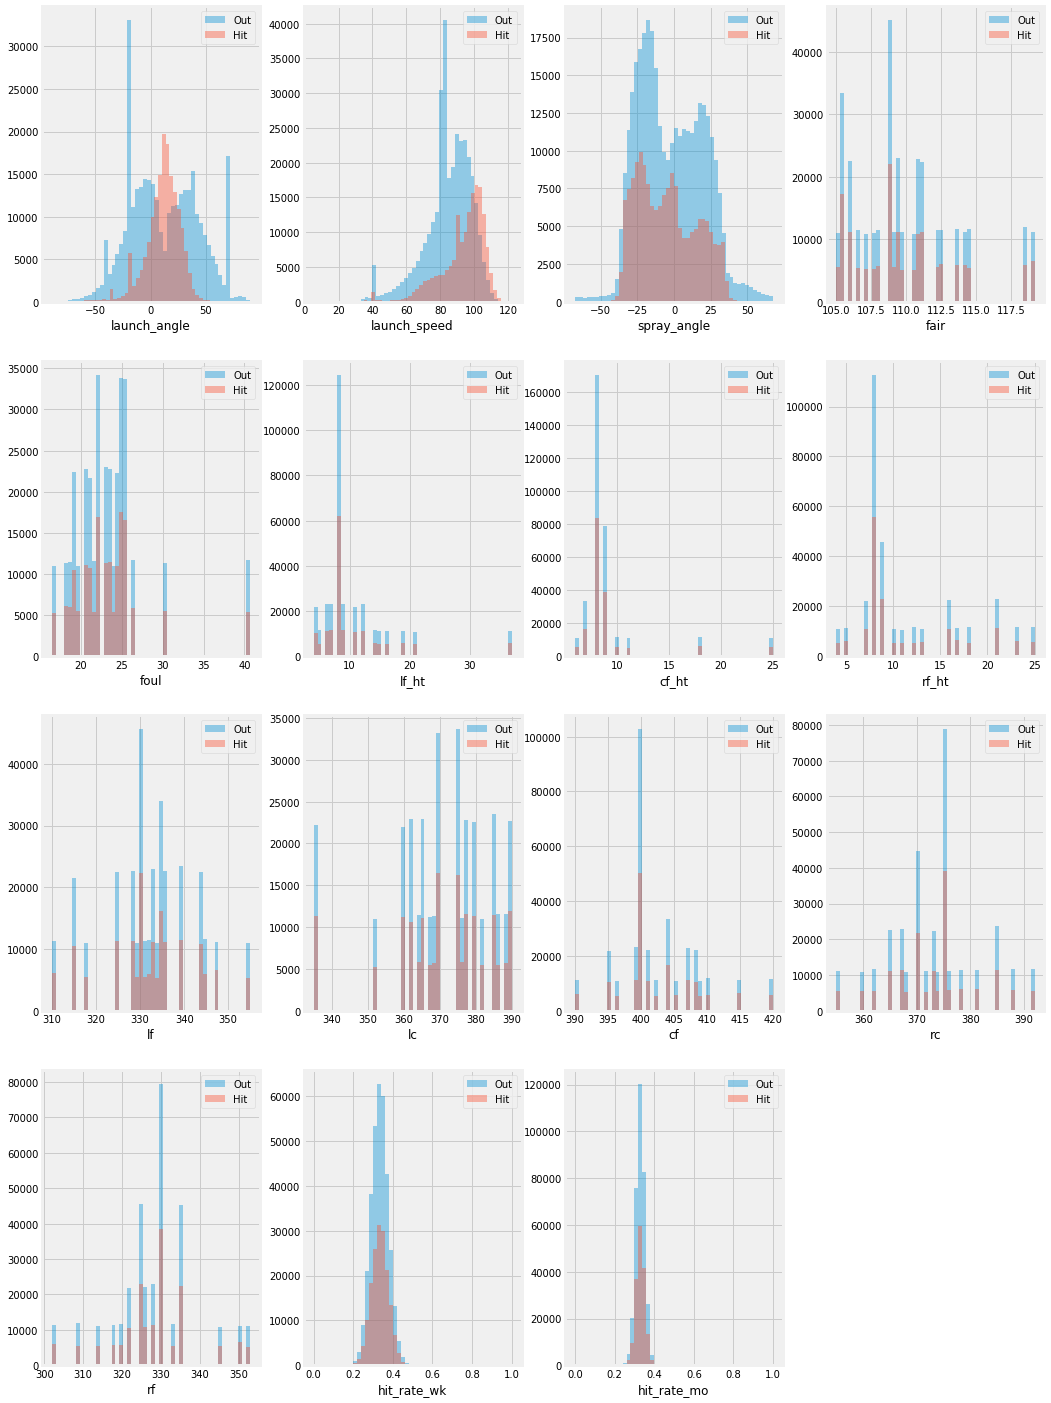

In [11]:
plt.figure(figsize=(16,25))
for i in range(len(cols)-1):
    plt.subplot(4, 4, i+1)
    sns.distplot(X_train.groupby('hit')[cols[i]].get_group(0), kde=False, label='Out');
    sns.distplot(X_train.groupby('hit')[cols[i]].get_group(1), kde= False, label='Hit');
    plt.legend();

We see that `launch_angle`, `launch_speed` and `spray_angle` are the only features whose distributions can provide clear discrimination between hits and outs. For `launch_angle` we see far more hits than outs for values between roughly 10 and 30 degrees and the reverse for other ranges. For `launch_speed`, more hits for values close to 100 mph and higher (and more outs for lower values). For `spray_angle` we see more hits relative to outs for a small range of negative values (perhaps these are batted balls pulled sharply down the line) and positive values (batted balls hit to an extreme to the opposite field). For the remaining features, there seems to be a near 2:1 ratio of outs to hits regardless of value (meaning in roughly the same proportions as the full data, so these features are likely not meaningful at all).

Let's now prepare to train our candidate model.

In [12]:
X_train = X_train.drop(columns='hit')
X_test = X_test.drop(columns='hit')

In [13]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [14]:
models = {
    'LogisticRegression': Pipeline(steps=[('sc', StandardScaler()), ('logistic', LogisticRegression(class_weight='balanced', random_state=42, solver='saga'))]),
    'LogisticRegression_SMOTE': Pipeline(steps=[('sc', StandardScaler()), ('logistic', LogisticRegression(random_state=42, solver='saga'))]),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'RandomForest_SMOTE': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting_ES': GradientBoostingClassifier(max_features=15, max_depth=10, random_state=42, n_iter_no_change=5, tol=.01)
}

For most of the models we'll be using `scikit-learn`'s defaults, aside from the instances of `LogisticRegressionClassifier` and `RandomForestClassifier` where we set `class_weight='balanced'` and `GradientBoostingClassifier` where we employ a version of [early stopping](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-early-stopping-py). We use the `saga` solver for `LogisticRegressionClassifier` to handle both `l1` and `l2` penalties, and also specify a `Pipeline` employing `StandardScaler` to standardize our features. For `GradientBoostingClassifier` we specify `max_features` equal to the total number of features we have and a basically arbitrary reasonable value for `max_depth`.

Below are the hyperparameter grids we will employ for `GridSearchCV` for each candidate model (note that we have also specified `max_features` equal to the total number of features for `RandomForestClassifier`.

In [15]:
param_grids = {
    'LogisticRegression': {
        'logistic__penalty': ['l1', 'l2'],
        'logistic__C': np.logspace(-3, 3, 7)
    },
    'RandomForest': {
        'max_features': [15],
        'max_depth': np.arange(2, 11, 1)
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [.01, .1, .5, 1]
    }
}

The code block below will train the candidate models, applying `SMOTE` when needed, collecting the following results from `GridSearchCV` for each:

* `Best_Params`, the highest-scoring set of hyperparameters,
* `Best_Estimator`, the highest-scoring estimator object,
* `Train` and `Test`, the highest-scoring estimator's mean train and test scores from 5-fold stratified cross-validation,
* `Feature_Imp`, the coefficients/feature importances of the highest-scoring estimator,
* `FPR` and `TPR`, the highest-scoring estimator's false and true positive rates when applying `roc_curve` to the estimator's positive class (hit) predictions (predicted probabilities) on the test data

In [16]:
model_results = {}
for name, model in models.items():
    
    use_grid = [k for k in param_grids.keys() if k in name][0]
    grid_search = GridSearchCV(estimator = model, param_grid = param_grids[use_grid], scoring='roc_auc', cv = skf, verbose = 2, return_train_score=True)
    
    if 'SMOTE' in name:
        X_res, y_res = SMOTE(random_state=42).fit_sample(X_train, y_train)
        grid_search.fit(X_res, y_res)
    else:
        grid_search.fit(X_train, y_train)
    test_score = grid_search.best_score_
    best_test_idx = np.argmax(grid_search.cv_results_['mean_test_score'])
    train_score = grid_search.cv_results_['mean_train_score'][best_test_idx]
    
    best_grid = grid_search.best_estimator_
    best_grid.fit(X_train, y_train)
    feat_imp = best_grid.named_steps['logistic'].coef_ if 'LogisticRegression' in name else best_grid.feature_importances_
    
    y_pred = best_grid.predict(X_test)
    if 'LogisticRegression' in name:
        fpr, tpr, thresholds = roc_curve(y_test, best_grid.predict_proba(X_test)[:,1])
    else:
        fpr, tpr, thresholds = roc_curve(y_test, best_grid.predict_proba(X_test)[:,1])
    
    model_results[name] = [grid_search.best_params_, grid_search.best_estimator_, train_score, test_score, feat_imp, fpr, tpr]
    

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.5s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.8s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.6s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.9s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   4.4s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   3.6s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   3.8s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   4.1s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .

[CV] .......... logistic__C=100.0, logistic__penalty=l2, total=   3.5s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.4s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.4s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.9s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.7s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.7s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l2, total=   3.3s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  4.8min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   5.2s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   5.2s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   6.3s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   5.9s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   6.1s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   5.7s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   5.2s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   5.6s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .

[CV] .......... logistic__C=100.0, logistic__penalty=l2, total=   5.7s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.0s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   5.9s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.5s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.3s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   5.8s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l2, total=   5.2s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  6.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=2, max_features=15, total=  17.4s
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s


[CV] ..................... max_depth=2, max_features=15, total=  16.1s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  22.0s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  11.8s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  13.1s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  17.5s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  19.1s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  16.8s
[CV] max_depth=3, max_features=15 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 32.5min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=2, max_features=15, total=  19.2s
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s remaining:    0.0s


[CV] ..................... max_depth=2, max_features=15, total=  18.1s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  18.4s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  18.7s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  18.7s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  26.7s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  28.4s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  26.8s
[CV] max_depth=3, max_features=15 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.3min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.3min
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.4min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.4min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.5min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.2min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 4.3min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=19.8min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 5.5min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] .

[CV] ................ learning_rate=1, n_estimators=200, total=  18.0s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 204.3min finished


In [17]:
df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Best_Params', 'Best_Estimator', 'Train', 'Test', 'Feature_Imp','FPR', 'TPR'])
df

,Best_Params,Best_Estimator,Train,Test,Feature_Imp,FPR,TPR
LogisticRegression,"{'logistic__C': 0.001, 'logistic__penalty': 'l1'}","(StandardScaler(), LogisticRegression(C=0.001,...",0.703743,0.703729,"[[-0.1270218819299402, 0.686988105357389, -0.0...","[0.0, 0.0, 0.0, 1.221433718899244e-05, 1.22143...","[0.0, 2.3807256451766497e-05, 7.14217693552995..."
LogisticRegression_SMOTE,"{'logistic__C': 0.001, 'logistic__penalty': 'l1'}","(StandardScaler(), LogisticRegression(C=0.001,...",0.704685,0.704665,"[[-0.10317710398150756, 0.7446102980244347, -0...","[0.0, 0.0, 0.0, 1.221433718899244e-05, 1.22143...","[0.0, 2.3807256451766497e-05, 7.14217693552995..."
RandomForest,"{'max_depth': 10, 'max_features': 15}","(DecisionTreeClassifier(max_depth=10, max_feat...",0.918845,0.911446,"[0.43952078259467564, 0.41582868352240115, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.442867437798488e-0...","[0.0, 0.004904294829063898, 0.0197124083420626..."
RandomForest_SMOTE,"{'max_depth': 10, 'max_features': 15}","(DecisionTreeClassifier(max_depth=10, max_feat...",0.920725,0.915640,"[0.430911244603423, 0.41702397040048395, 0.139...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.221433718899244e-0...","[0.0, 0.004904294829063898, 0.0197124083420626..."
GradientBoosting_ES,"{'learning_rate': 0.1, 'n_estimators': 50}",([DecisionTreeRegressor(criterion='friedman_ms...,0.933801,0.918525,"[0.41175878697679685, 0.3959677507973093, 0.15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.3807256451766497e-05, 0.00014284353871..."


From the above results from training our candidate models, the `GradientBoostingClassiier` appears to perform best, followed closely by both `RandomForestClassifier` models, with both `LogisticRegressionClassifier` models well behind. It also looks like using `SMOTE` doesn't really perform much differently from using `class_weight='balanced'` for the latter two types of classifiers.

We will go ahead and select `GradientBoostingClassifier` as "best" and the classifier to continue to optimize. While it only marginally performs better than `RandomForestClassifier`, it appears the `Best_Estimator` for that model is "artificially" optimized with the maximum values of `max_depth` (and some previous work showed this is true if we vary `max_features` and `n_estimators`), which may be overfitting some -- while our specification of `GradientBoostingClassifier` is attempting to reduce overfitting.

Below, we plot the ROC curves of each `Best_Estimator` for further evidence of the performance of our version of `GradientBoostingClassifier` over the other candidate models.

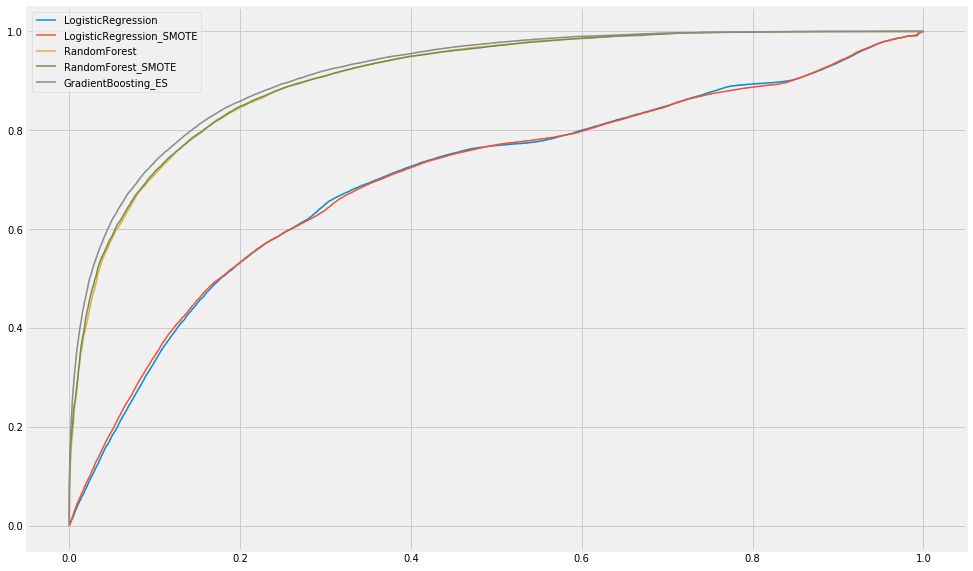

In [18]:
plt.figure(figsize=(15,10))
for i,row in df.iterrows():
    plt.plot(row['FPR'], row['TPR'], lw=1.5, label=i)
plt.legend()

Let's now more exhaustively tune hyperparameters for this "best" version of `GradientBoostingClassifier`. We'll do these in sequence for now, first `max_depth`, then `max_features`, then `n_estimators` (the number of trees) and finally the `learning_rate`.

We'll be scoring using `fbeta_score` with `beta = 2` and create a custom scorer first to pass to `GridSearchCV`:

In [19]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

### Max Depth

In [20]:
gb_depth = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, tol=.01)
depth_grid = {
    'max_depth': np.arange(1, 21, 1)
}
depth_search = GridSearchCV(estimator = gb_depth, param_grid = depth_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [21]:
depth_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=1, total=  15.4s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


[CV] ...................................... max_depth=1, total=  18.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  17.3s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  16.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  14.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  28.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  35.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  30.8s
[CV] max_depth=2 .....................................................
[CV] .

[CV] ..................................... max_depth=12, total= 1.8min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 2.1min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 2.0min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 1.9min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 1.9min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 2.0min
[CV] max_depth=14 ....................................................
[CV] ..................................... max_depth=14, total= 2.2min
[CV] max_depth=14 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 801.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [22]:
depth_train = depth_search.cv_results_['mean_train_score']
depth_test = depth_search.cv_results_['mean_test_score']

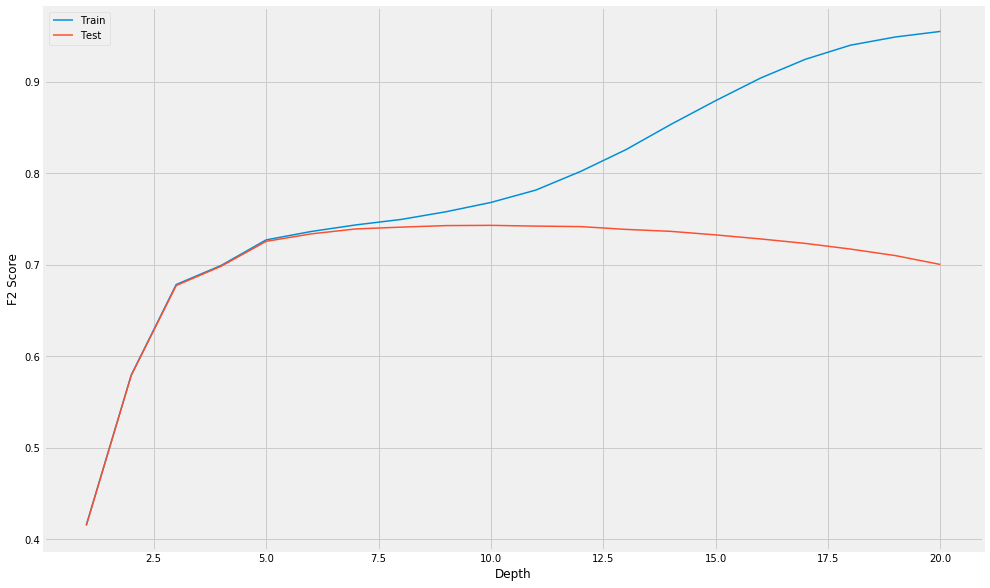

In [23]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,21,1), depth_train, lw=1.5, label='Train')
plt.plot(np.arange(1,21,1), depth_test, lw=1.5, label='Test')
plt.xlabel('Depth')
plt.ylabel('F2 Score')
plt.legend()

In [24]:
depth_search.best_params_

{'max_depth': 10}

After searching through `max_depth` values from 1 through 20, the cross-validation results above show that at a depth of around 6-7, the training and validation scores begin to diverge. From a depth of 9-10, training scores diverge even more and increase at a higher rate while the test scores plateau and then decline -- at depth 10, the validation score is highest, from this point the model overfits on the training data and isn't improving.

We'll now proceed to tuning `max_features` using a `max_depth` of 10:

### Max Features

In [25]:
gb_feat = GradientBoostingClassifier(max_depth=10, random_state=42, n_iter_no_change=5, tol=.01)
feat_grid = {
    'max_features': np.arange(4, 16, 1)
}
feat_search = GridSearchCV(estimator = gb_feat, param_grid = feat_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [26]:
feat_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... max_features=4, total=  43.4s
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.5s remaining:    0.0s


[CV] ................................... max_features=4, total=  42.6s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  43.2s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  40.5s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  39.2s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  43.9s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  48.2s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  42.5s
[CV] max_features=5 ..................................................
[CV] .

[CV] .................................. max_features=15, total= 1.7min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 69.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_depth=10,
                                                  n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'max_features': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [27]:
feat_train = feat_search.cv_results_['mean_train_score']
feat_test = feat_search.cv_results_['mean_test_score']

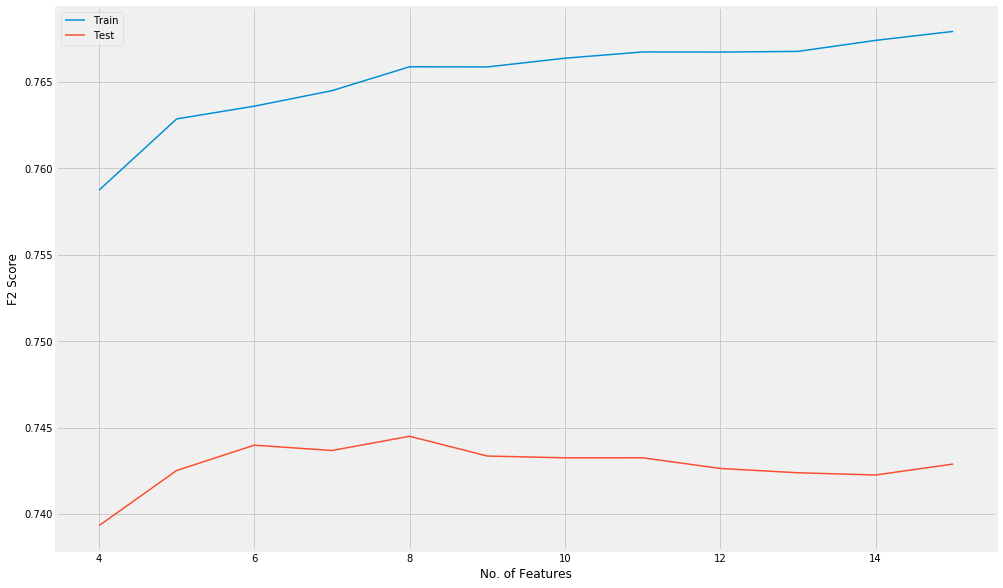

In [28]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(4,16,1), feat_train, lw=1.5, label='Train')
plt.plot(np.arange(4,16,1), feat_test, lw=1.5, label='Test')
plt.xlabel('No. of Features')
plt.ylabel('F2 Score')
plt.legend()

As with `max_depth`, though in less stark fashion, we see that our search over `max_features` values from 4 through 15 (the full number of features) also results in training scores improving at a different rate than validation scores before continuing to increase while validation scores plateau and decline. When `max_features` is at 6 features, the training scores begin to improve more rapidly, and at about 9 features, the validation scores stop improving as the model overfits more on the training data.

We will end by tuning `n_estimators` with `max_depth` at 10 and `max_features` at 8 features:

### Number of Trees

In [29]:
gb_trees = GradientBoostingClassifier(max_depth=10, max_features=8, random_state=42, n_iter_no_change=5, tol=.01)
trees_grid = {
    'n_estimators': np.arange(20, 210, 10)
}
tree_search = GridSearchCV(estimator = gb_trees, param_grid = trees_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [30]:
tree_search.fit(X_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=20, total=  37.8s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s remaining:    0.0s


[CV] .................................. n_estimators=20, total=  38.6s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  37.8s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  37.4s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  36.0s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=  59.7s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=  57.6s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total= 1.0min
[CV] n_estimators=30 .................................................
[CV] .

[CV] ................................. n_estimators=130, total=  55.9s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  56.3s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  56.0s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  54.6s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  57.4s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  56.3s
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=  56.2s
[CV] n_estimators=150 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed: 96.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_depth=10, max_features=8,
                                                  n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190, 200])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [31]:
trees_train = tree_search.cv_results_['mean_train_score']
trees_test = tree_search.cv_results_['mean_test_score']

In [32]:
trees_test

array([0.7312938 , 0.74300005, 0.74449612, 0.74449612, 0.74449612,
       0.74449612, 0.74449612, 0.74449612, 0.74449612, 0.74449612,
       0.74449612, 0.74449612, 0.74449612, 0.74449612, 0.74449612,
       0.74449612, 0.74449612, 0.74449612, 0.74449612])

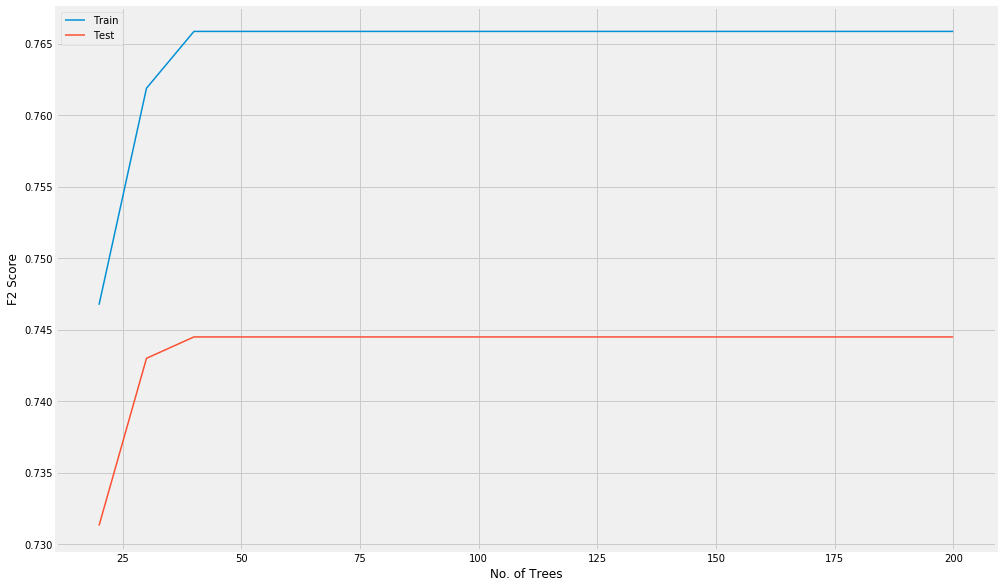

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(20, 210, 10), trees_train, lw=1.5, label='Train')
plt.plot(np.arange(20, 210, 10), trees_test, lw=1.5, label='Test')
plt.xlabel('No. of Trees')
plt.ylabel('F2 Score')
plt.legend()

Our search over values of `n_estimators` from 20 to 200 (in increments of 10) find that both train and validation scores basically level off and do not improve beyond 40 estimators.

Finally, let's tune `learning_rate` with `max_depth = 10`, `max_features=8` and `n_estimators=40`.

In [36]:
gb_learn = GradientBoostingClassifier(max_depth=10, max_features=8, n_estimators=40, random_state=42, n_iter_no_change=5, tol=.01)
learn_grid = {
    'learning_rate': [.01, .05, .1, .15, .2, .3, .4, .5, .75, 1]
}
learn_search = GridSearchCV(estimator = gb_learn, param_grid = learn_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [37]:
learn_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] learning_rate=0.01 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... learning_rate=0.01, total= 1.4min
[CV] learning_rate=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ............................... learning_rate=0.01, total= 1.4min
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total= 1.2min
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total= 1.2min
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total= 1.2min
[CV] learning_rate=0.05 ..............................................
[CV] ............................... learning_rate=0.05, total= 1.3min
[CV] learning_rate=0.05 ..............................................
[CV] ............................... learning_rate=0.05, total= 1.2min
[CV] learning_rate=0.05 ..............................................
[CV] ............................... learning_rate=0.05, total= 1.3min
[CV] learning_rate=0.05 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 36.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_depth=10, max_features=8,
                                                  n_estimators=40,
                                                  n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4,
                                           0.5, 0.75, 1]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [40]:
learn_train = learn_search.cv_results_['mean_train_score']
learn_test = learn_search.cv_results_['mean_test_score']

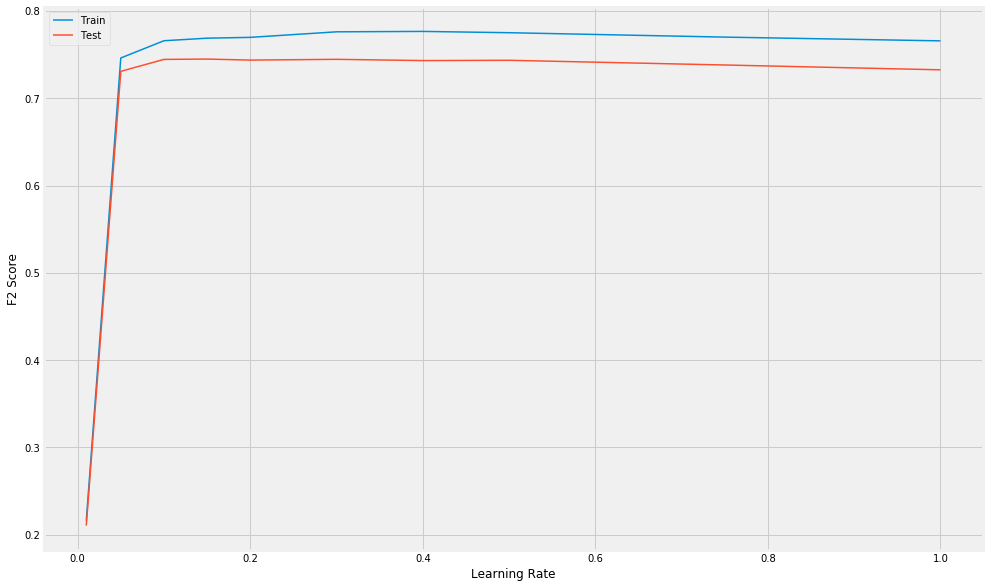

In [41]:
plt.figure(figsize=(15, 10))
plt.plot([.01, .05, .1, .15, .2, .3, .4, .5, .75, 1], learn_train, lw=1.5, label='Train')
plt.plot([.01, .05, .1, .15, .2, .3, .4, .5, .75, 1], learn_test, lw=1.5, label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('F2 Score')
plt.legend()

In [42]:
learn_search.best_params_

{'learning_rate': 0.15}

The `learning_rate` search shows that our validation scores peak at a value of 0.15 after which the model will marginally overfit on the training data.

Our final `GradientBoostingClassifier` model will thus use:

* `n_estimators = 40`
* `max_depth = 10`
* `max_features = 8`
* `learning_rate = 0.15`

In the next notebook, we'll fit this model on the entirety of the training data, look at feature importances of this fit, and then evaluate it on the test data. Using the model's predictions on the test data, we'll then try to make some sense of the correct and incorrect predictions and what that means for this and future modeling efforts.